## Imports

In [210]:
#Library imports
import re
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2


#User Created functions

from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [ ]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

In [5]:
train_data = np.load("data/kuzushiji49/train/k49-train-imgs.npz")['arr_0']
train_labels = np.load("data/kuzushiji49/train/k49-train-labels.npz")['arr_0']
test_data = np.load("data/kuzushiji49/test/k49-test-imgs.npz")['arr_0']
test_labels = np.load("data/kuzushiji49/test/k49-test-labels.npz")['arr_0']
classmap = pd.read_csv("data/kuzushiji49/k49_classmap.csv")

## EDA

The data from the kuzushiji dataset in it's initial state is relatively straightforward, there are over 200,000 observations across 49 classes (Some appear to be better represented than others). The image resolution is very small (28x28) and the lack of color channels indicate greyscale images.

In [382]:
train_data.shape

(232365, 28, 28)

In [6]:
full_value_counts(pd.DataFrame(train_labels), 0)

There are 49 unique values with 0 nan values making up 0.0%
6000-24 --2.58%
6000-27 --2.58%
6000-47 --2.58%
6000-21 --2.58%
6000-20 --2.58%
6000-19 --2.58%
6000-18 --2.58%
6000-17 --2.58%
6000-15 --2.58%
6000-12 --2.58%
6000-11 --2.58%
6000-10 --2.58%
6000-9 --2.58%
6000-7 --2.58%
6000-6 --2.58%
6000-5 --2.58%
6000-4 --2.58%
6000-2 --2.58%
6000-1 --2.58%
6000-25 --2.58%
6000-0 --2.58%
6000-28 --2.58%
6000-46 --2.58%
6000-30 --2.58%
6000-41 --2.58%
6000-40 --2.58%
6000-39 --2.58%
6000-38 --2.58%
6000-34 --2.58%
6000-35 --2.58%
6000-37 --2.58%
5132-26 --2.21%
4714-8 --2.03%
4165-13 --1.79%
3867-14 --1.66%
3523-48 --1.52%
3394-33 --1.46%
3060-31 --1.32%
2565-16 --1.10%
2451-23 --1.05%
2397-43 --1.03%
2139-42 --0.92%
2063-22 --0.89%
1993-29 --0.86%
1718-32 --0.74%
1598-36 --0.69%
777-3 --0.33%
417-44 --0.18%
392-45 --0.17%


The small resolution does not impede the distinguishability of these glyphs. Everything appears to use the space as full as possible where the edges are cropped based on the size of the writing.

In [129]:
bulk_character_viewer(data=train_data, labels=map_char_codes(train_labels, classmap), indices=(0,60), columns=15)

The earlier list of classification labels revealed that some characters have much better representation than others in the dataset. It would help to group the data for visualization with a barchart.

In [28]:
counts = pd.Series(train_labels).reset_index().groupby(0).count().reset_index().rename(columns={0:"index", "index":"count"})
counts = counts.merge(classmap, how="left", on="index")

There is a fairly large class imbalance for roughly 1/3 of the values. The two characters with the least observations had actually been officially declared obsolete in the mid 40s so it is reasonable to expect that they would be less common throughout historical literature. The lack of presence of the character え in the dataset of classical texts is a bit harder to explain.

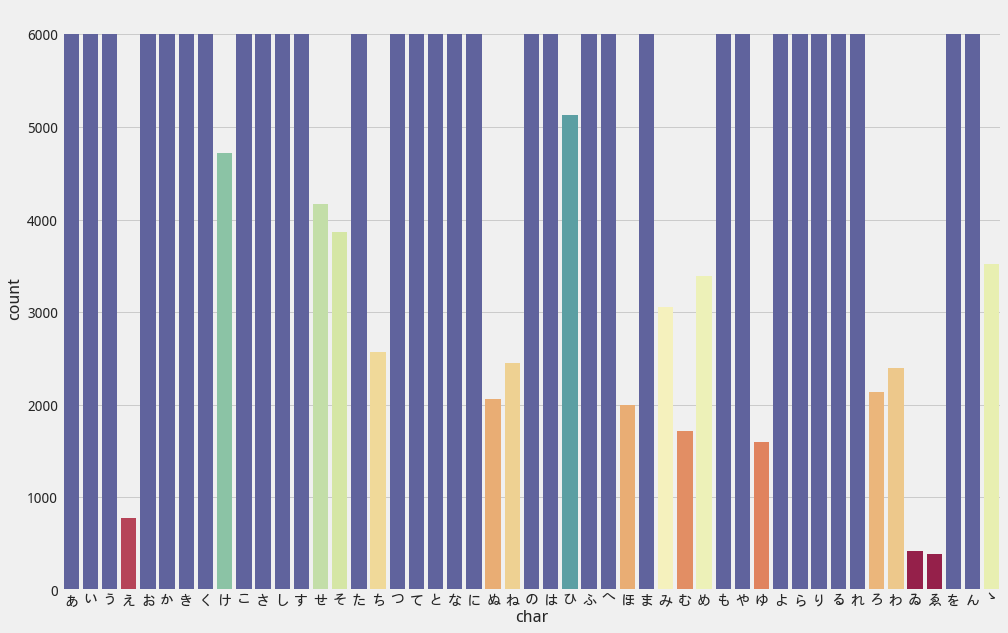

In [51]:
warnings.filterwarnings('ignore')
fig, ax = common_plot_setup(style="fivethirtyeight", font="Droid Sans")
sns.barplot("char", "count", data=counts, ax=ax, palette=colors_from_values(counts["count"], 'Spectral'))
plt.xticks(fontname = "Droid Sans Japanese")
plt.show()
warnings.filterwarnings('default')

## Preprocessing

I created several functions to handle the preprocessing that give a reasonable degree of flexibility to handle tweaks that may be necessary during the modeling process. The order of operations is essentially adding padding to the image boundaries, converting the rgb values to normalized floats, splitting the training data into training and validation sets, resampling the training data to account for the class imbalance, and finally expanding the vector labels into a matrix.

In [23]:
def preprocess_raster_common(array, bits=8, x_pad=0, y_pad=0):
    X = array.copy()
    X = pad_raster_edges(X, x_pad, y_pad)
    X = color_values_to_float(X, bits)
    return images_to_1d(X)

def preprocess_raster_pipeline(array, labels, bits=8, resample=None, random_state=None, test_size=None, x_pad=0, y_pad=0):
    X = preprocess_raster_common(array, bits, x_pad, y_pad)
    y = labels.copy()
    
    if test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_train, y_train = preprocess_raster_resampling(X_train, y_train, resample, random_state)
        return X_train, X_test, to_categorical(y_train), to_categorical(y_test)
    else:
        X, y = preprocess_raster_resampling(X, y, resample, random_state)
        return X, to_categorical(y)

Through the process, I found that my models had better results when the class imbalance was rectified through the SMOTE algorithm. I also added two pixels of padding on each side for several reasons.
* To preserve data when passed through CNN filters
* The clean boundaries at the edges will also minimize cropping and unwanted artifacts when transformations are applied with the image generator.
* A 32x32 matrix created more options than a 28x28 matrix when transfer learning with pretrained models.

In [24]:
X_train, X_val, y_train, y_val = preprocess_raster_pipeline(train_data, train_labels, resample="smote", test_size=.2,
                                                            random_state = SEED, x_pad=2, y_pad=2)
X_test, y_test = preprocess_raster_pipeline(test_data, test_labels, x_pad=2, y_pad=2)

performing SMOTE
Ignoring class imbalances


The function above transformed each observation into a vector. However I also needed to create a version of the data that restores the missing dimensions for shape compatibility with convolutional network filters and the pretrained models for transfer learning. In the case of transfer learning, I duplicated the channel data twice for compatibility with Keras's selection of pretrained models.

In [25]:
X_train_2d = images_to_1d(X_train, 32, 32, 1, True)
X_train_2d = np.repeat(X_train_2d, 3, axis=3)

X_val_2d = images_to_1d(X_val, 32, 32, 1, True)
X_val_2d = np.repeat(X_val_2d, 3, axis=3)

X_test_2d = images_to_1d(X_test, 32, 32, 1, True)
X_test_2d = np.repeat(X_test_2d, 3, axis=3)


Introducing random transformations to extend the scope of the dataset. For text in this particular context it is better to avoid using a heavy handed approach especially since there are so many classifiers. The small values passed in the arguments reflect that.

In [26]:
train_generator = ImageDataGenerator(rotation_range=4, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
X_train_generator = train_generator.flow(X_train_2d, y_train, batch_size = 32)

## Modeling

### Baseline_prediction

For my baseline predictor, I leveraged an sklearn module that makes random predictions where the likelihood of a given prediction is determined by it's frequency within the training data. Because there are so many classes, the likelihood of a high accuracy score due to chance or imbalance in the classes is low.

In [8]:
baseline_predictor = DummyClassifier(strategy="stratified", random_state=SEED)
baseline_predictor.fit(train_data, train_labels)
y_hat = baseline_predictor.predict(test_data)
image_class_accuracy_scores(test_labels, y_hat)

Accuracy: 0.02373725581757335
Balanced Accuracy: 0.020786811169094116


(0.02373725581757335, 0.020786811169094116)

### A simple deep learning model

Before increasing processing time with the convolutional layers, I also constructed a simple deep learning network that has a much faster performance. I found that incorporating in some regularization was beneficial to the scores on the test data

In [55]:
lambda_coef = .0005
layers = [Dense(64, "relu", input_shape=(1024,),kernel_regularizer=l2(lambda_coef)),
          Dense(56, activation='relu', kernel_regularizer=l2(lambda_coef)),
          Dense(49, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0003), "metrics":['accuracy']}
model1 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_7 (Dense)              (None, 56)                3640      
_________________________________________________________________
dense_8 (Dense)              (None, 49)                2793      
Total params: 72,033
Trainable params: 72,033
Non-trainable params: 0
_________________________________________________________________


In [56]:
backups1 = ModelCheckpoint("model_backups/model1-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results1 = model1.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[backups1, stopping])

Train on 239659 samples, validate on 46473 samples
Epoch 1/200
238720/239659 [============================>.] - ETA: 0s - loss: 1.6148 - accuracy: 0.6331WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_backups/model1-01/assets
239659/239659 [==============================] - 8s 34us/sample - loss: 1.6132 - accuracy: 0.6335 - val_loss: 1.3021 - val_accuracy: 0.7003
Epoch 2/200
239659/239659 [==============================] - 8s 32us/sample - loss: 1.1058 - accuracy: 0.7565 - val_loss: 1.1315 - val_accuracy: 0.7468
Epoch 3/200
239659/239659 [==============================] - 8s 32us/sample - loss: 0.9765 - accuracy: 0.7891 - val_loss: 1.028

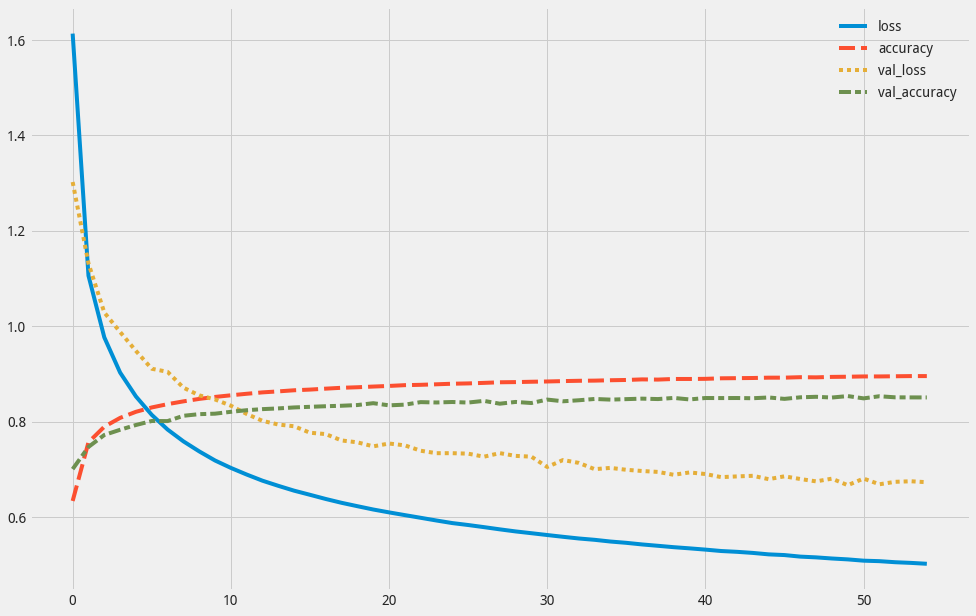

,loss,accuracy,val_loss,val_accuracy
49,0.511024,0.893937,0.666517,0.853399
50,0.508340,0.894550,0.680457,0.848579
51,0.507304,0.894550,0.668478,0.853033
52,0.505085,0.894917,0.673646,0.850752
53,0.503678,0.895280,0.674794,0.850580
54,0.501797,0.895264,0.672794,0.850515


In [74]:
plot_keras_fit_history(results1, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail(6)

In [85]:
image_class_evaluation(model1, X_test, y_test)

Accuracy: 0.7601369756401276
Balanced Accuracy: 0.7606392958931727


(0.7601369756401276, 0.7606392958931727)

### A simple convolutional model.

While the 76% accuracy well outperformed the baseline, there was some room for improvement, so I introduced some convolutional layers. There were initial signs that the learning rate was too high

In [70]:
layers = [Conv2D(32, (3, 3), activation='relu', input_shape=(32 ,32,  3)),
          MaxPooling2D((2, 2)),
          Conv2D(100, (3, 3), activation='relu'),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(80, "relu"),
          Dense(49, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0002), "metrics":['accuracy']}
model2 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 100)       28900     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 100)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 80)                288080    
_________________________________________________________________
dense_18 (Dense)             (None, 49)               

In [71]:
backups2 = ModelCheckpoint("model_backups/model2-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results2 = model2.fit(X_train_generator, epochs=200, steps_per_epoch=7489, validation_data=(X_val_2d, y_val), callbacks=[backups2, stopping])

  ...
    to  
  ['...']
Train for 7489 steps, validate on 46473 samples
Epoch 1/200
7489/7489 [==============================] - 90s 12ms/step - loss: 1.0531 - accuracy: 0.7281 - val_loss: 0.4451 - val_accuracy: 0.8806
Epoch 2/200
7489/7489 [==============================] - 93s 12ms/step - loss: 0.5001 - accuracy: 0.8649 - val_loss: 0.3303 - val_accuracy: 0.9097
Epoch 3/200
7489/7489 [==============================] - 92s 12ms/step - loss: 0.3760 - accuracy: 0.8964 - val_loss: 0.2659 - val_accuracy: 0.9268
Epoch 4/200
7489/7489 [==============================] - 90s 12ms/step - loss: 0.3106 - accuracy: 0.9147 - val_loss: 0.2375 - val_accuracy: 0.9337
Epoch 5/200
7489/7489 [==============================] - 90s 12ms/step - loss: 0.2698 - accuracy: 0.9256 - val_loss: 0.2100 - val_accuracy: 0.9433
Epoch 6/200
7489/7489 [==============================] - 90s 12ms/step - loss: 0.2385 - accuracy: 0.9332 - val_loss: 0.2116 - val_accuracy: 0.9413
Epoch 7/200
7489/7489 [======================

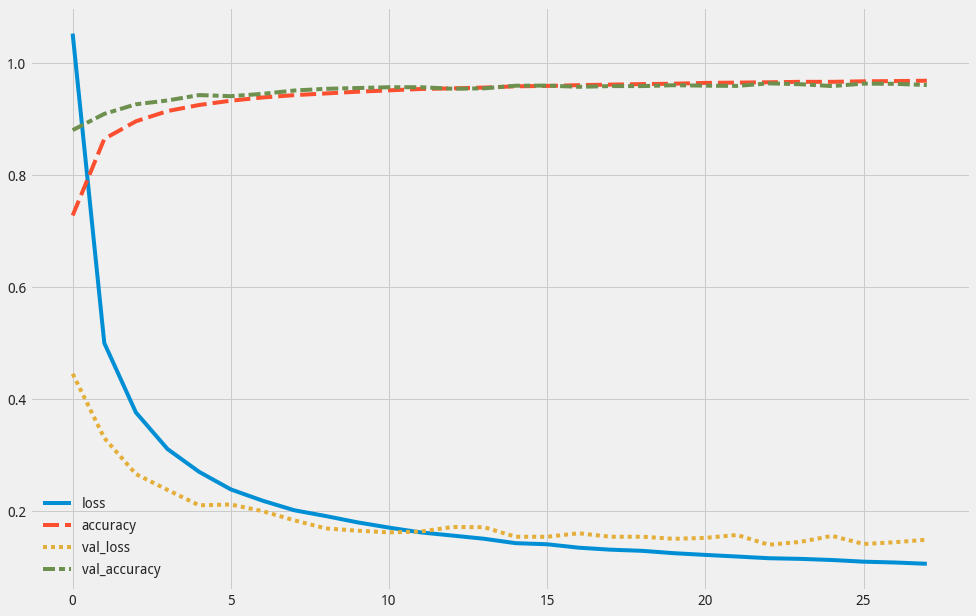

,loss,accuracy,val_loss,val_accuracy
23,0.114332,0.966957,0.144701,0.962688
24,0.112323,0.966919,0.155453,0.959353
25,0.109327,0.967883,0.140979,0.963742
26,0.107842,0.968309,0.144092,0.963377
27,0.105548,0.968918,0.148619,0.961203


In [73]:
plot_keras_fit_history(results2, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [86]:
image_class_evaluation(model2, X_test_2d, y_test)

Accuracy: 0.9379458842452072
Balanced Accuracy: 0.9292542458646226


(0.9379458842452072, 0.9292542458646226)

### Transfer learning from the VGG16 model trained from ImageNet

Next I explored the possibility of transfer learning from models already built with much larger datasets. There seemed to be an absence of pretrained OCR models out there, so the input data required duplication to give the appearence of having three color channels for compatibility with the model.

In [99]:
from tensorflow.keras.applications import VGG16
transfer_layers = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(32, 32, 3))

In [100]:
transfer_layers.trainable = True
set_trainable = False
for layer in transfer_layers.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [101]:
layers = [transfer_layers,
          Flatten(),
          Dense(80, "relu"),
          Dense(49, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.000075), "metrics":['accuracy']}
model3 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 80)                41040     
_________________________________________________________________
dense_28 (Dense)             (None, 49)                3969      
Total params: 14,759,697
Trainable params: 14,499,537
Non-trainable params: 260,160
_________________________________________________________________


In [102]:
backups3 = ModelCheckpoint("model_backups/model3-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results3 = model3.fit(X_train_generator, epochs=200, steps_per_epoch=7489, validation_data=(X_val_2d, y_val), callbacks=[backups3, stopping])

  ...
    to  
  ['...']
Train for 7489 steps, validate on 46473 samples
Epoch 1/200
7489/7489 [==============================] - 183s 24ms/step - loss: 0.3752 - accuracy: 0.9021 - val_loss: 0.2069 - val_accuracy: 0.9460
Epoch 2/200
7489/7489 [==============================] - 188s 25ms/step - loss: 0.1424 - accuracy: 0.9628 - val_loss: 0.1767 - val_accuracy: 0.9595
Epoch 3/200
7489/7489 [==============================] - 180s 24ms/step - loss: 0.1069 - accuracy: 0.9715 - val_loss: 0.1264 - val_accuracy: 0.9691
Epoch 4/200
7489/7489 [==============================] - 189s 25ms/step - loss: 0.0891 - accuracy: 0.9763 - val_loss: 0.1226 - val_accuracy: 0.9716
Epoch 5/200
7489/7489 [==============================] - 189s 25ms/step - loss: 0.0779 - accuracy: 0.9793 - val_loss: 0.0999 - val_accuracy: 0.9771
Epoch 6/200
7489/7489 [==============================] - 190s 25ms/step - loss: 0.0686 - accuracy: 0.9813 - val_loss: 0.1272 - val_accuracy: 0.9706
Epoch 7/200
7489/7489 [================

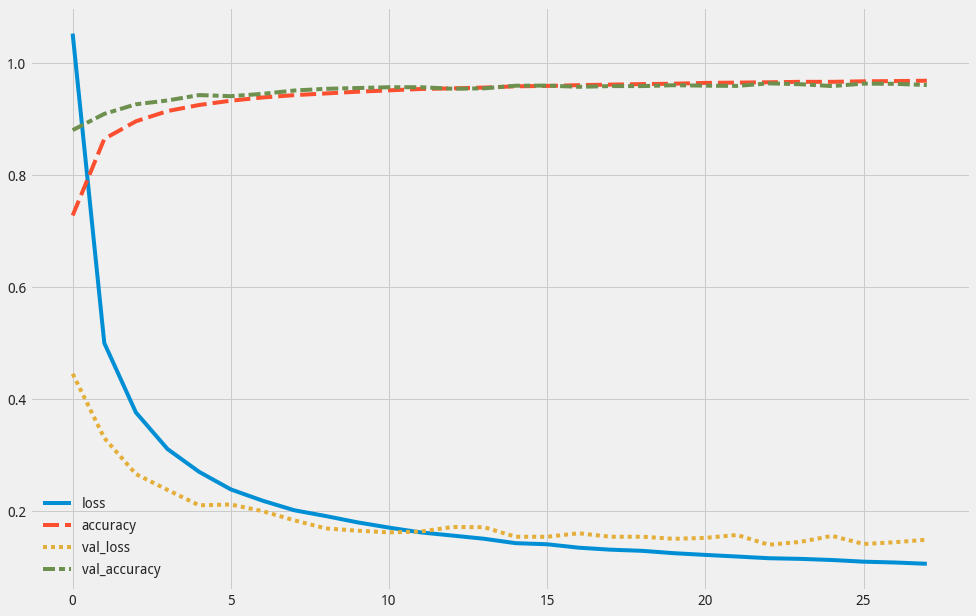

,loss,accuracy,val_loss,val_accuracy
23,0.114332,0.966957,0.144701,0.962688
24,0.112323,0.966919,0.155453,0.959353
25,0.109327,0.967883,0.140979,0.963742
26,0.107842,0.968309,0.144092,0.963377
27,0.105548,0.968918,0.148619,0.961203


In [103]:
plot_keras_fit_history(results2, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [104]:
image_class_evaluation(model3, X_test_2d, y_test)

Accuracy: 0.9593742703712351
Balanced Accuracy: 0.9562769703806372


(0.9593742703712351, 0.9562769703806372)

## Evaluation

### Where the model fell short

To help get better context behind the model's accuracy and potential room for growth, at this point it would help to take a closer look at where it went wrong.

In [167]:
raw_predictions = model3.predict(X_test_2d)
prediction_labels = np.argmax(raw_predictions, axis=1)
probabilities = pd.DataFrame(raw_predictions[error_selection], columns = classmap["char"].values)

In [383]:
#This creates a mask that will allow easy selection among the cases where the model resulted in a misclassification.
error_selection = (prediction_labels != test_labels)

In [177]:
bulk_character_viewer(data=test_data[error_selection],
                      labels=map_char_codes(test_labels[error_selection], classmap),
                      predictions=map_char_codes(prediction_labels[error_selection], classmap),
                      indices=(0,50), columns=10)

One common occurrence in the misclassified predictions involves the now obsolete iteration mark for character repetition (ゝ). While in a few cases it clearly misses the mark, there are several instances where it is understandably confused with the character ku (く). Because in the dataset of the kuzushiji writing style it often appears inverted in along the vertical axis, it would be quite a difficult task for a human to discern the differences between the two under these conditions.

In [155]:
bulk_character_viewer(data=train_data[train_labels==48],
                      labels=map_char_codes(train_labels[train_labels==48], classmap),
                      indices=(0,36), columns=12)

In [379]:
bulk_character_viewer(data=train_data[train_labels==7],
                      labels=map_char_codes(train_labels[train_labels==7], classmap),
                      indices=(0,36), columns=12)

Other outright misses due to the apparent contradictions in the data can be seen in the above images at 5, 9, and 40. Others were close calls. For example in the case of image 22 where there was a prediction that had mistaken so(そ) for u(う), the model was nearly equally divided in it's decision between the two.

In [191]:
probabilities.iloc[22].sort_values(ascending=False).head(4)

う    0.516809
そ    0.471877
か    0.007497
り    0.000700
Name: 22, dtype: float32

## Hidden layers

To help understand this prediction, I turned to the hidden layers in the convolutional layers.

In [270]:
#The because this was a transfer learning model, the cnn layers from the imported model are all located within the first layer.
cnn_outputs = [layer.output for layer in model3.layers[0].layers[:20]]
dense_outputs = [layer.output for layer in model3.layers[1:4]]

#I've created seperate models to track the outputs in the cnn and dense layers
all_activations = models.Model(inputs=[model3.layers[0].input, model3.input], outputs=[*cnn_outputs, *dense_outputs])
cnn_activations = models.Model(inputs=model3.layers[0].input, outputs=cnn_outputs)
intermediate_predictor = models.Model(inputs=model3.layers[0].input, outputs=[cnn_outputs[-1]])
#dense_activations = models.Model(inputs=Input([1, 1, 512]), outputs=dense_outputs)

In [252]:
so_mistaken = np.expand_dims(X_test_2d[error_selection][22], axis=0)

In [271]:
cnn_layers = cnn_activations.predict(so_mistaken)
so_intermediate = intermediate_predictor.predict(so_mistaken)
#dense_layers = cnn_activations.predict(so_intermediate)

In [294]:
second_layer_activation = cnn_layers[1]
print(second_layer_activation.shape)

(1, 32, 32, 64)


In the early early layers (that were frozen during training) it's seperating out various low level features of the character but there appears to be more than a few channels that closely resemble others.

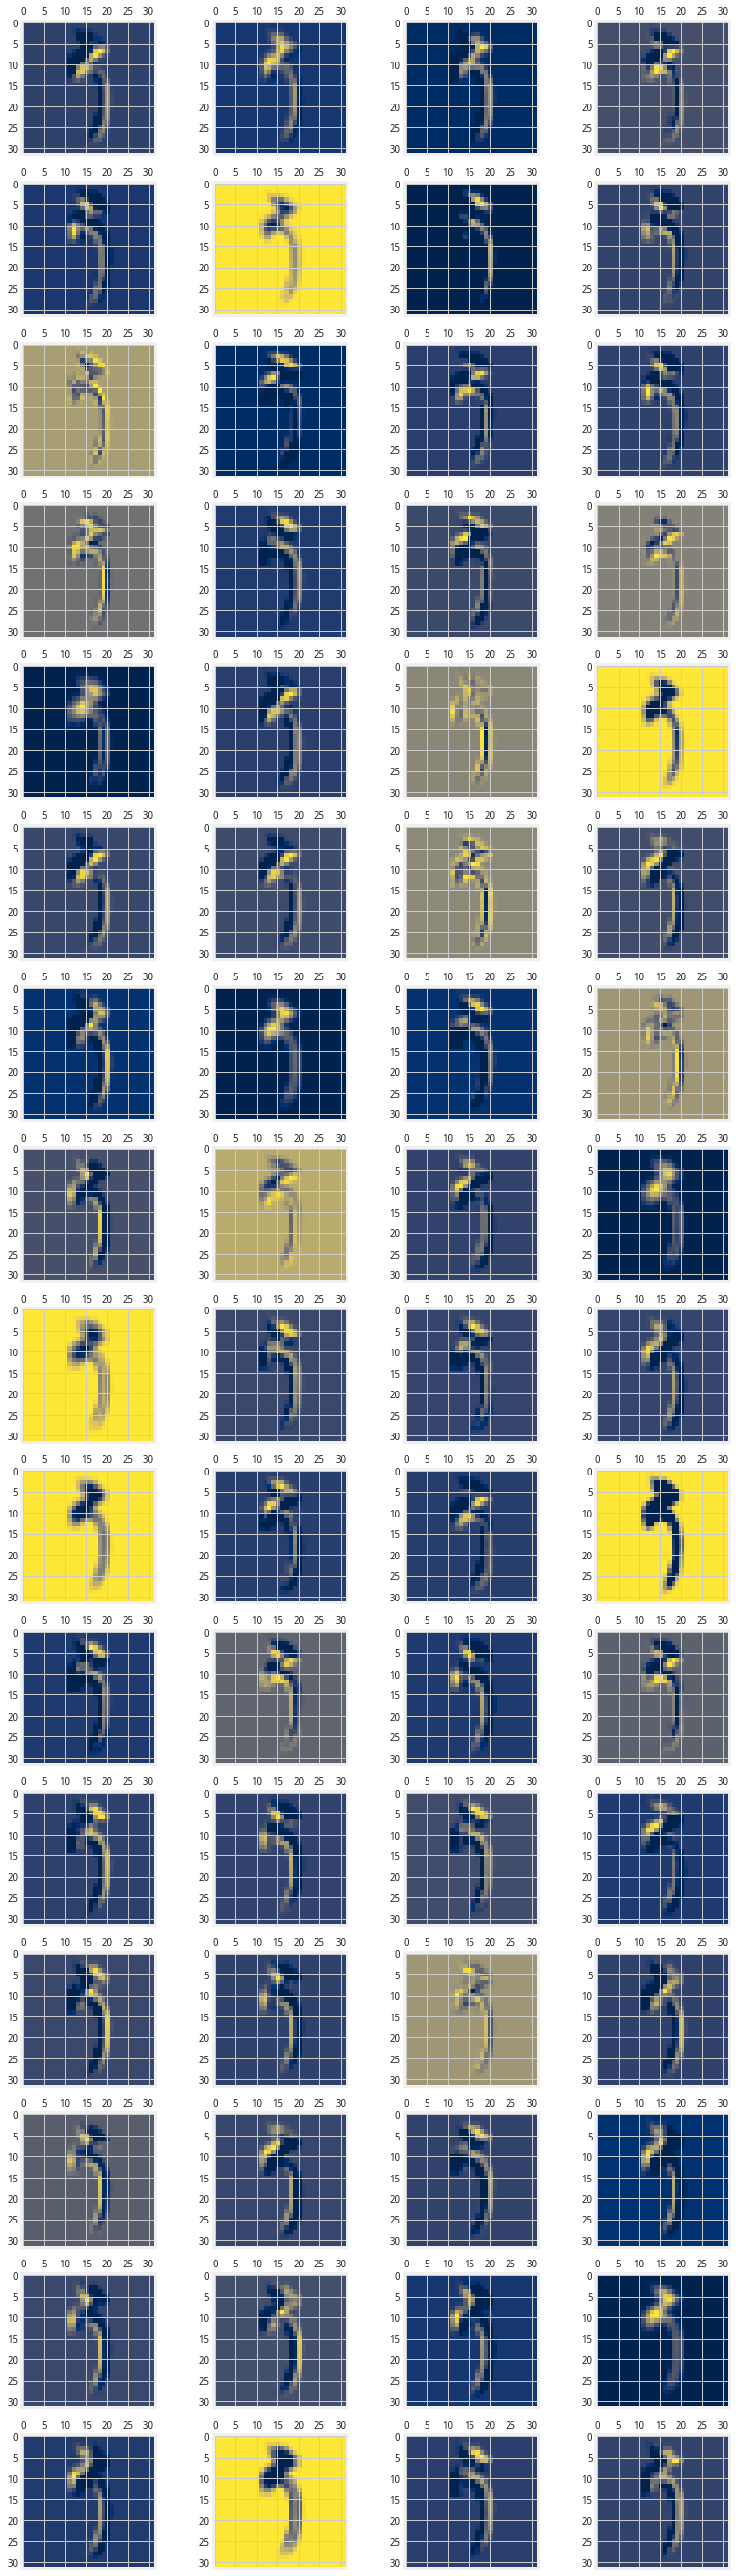

In [375]:
fig, axes = plt.subplots(16, 4, figsize=(12,48))
for i in range(64):
    row = i//4
    column = i%4
    ax = axes[row, column]
    ax.matshow(second_layer_activation[0, :, :, i], cmap='cividis')

Farther down the line the features become more abstract. The ones below had their weights adjusted with the new training.

In [343]:
fourth_layer_activation = cnn_layers[3]
print(fourth_layer_activation.shape)

(1, 16, 16, 64)


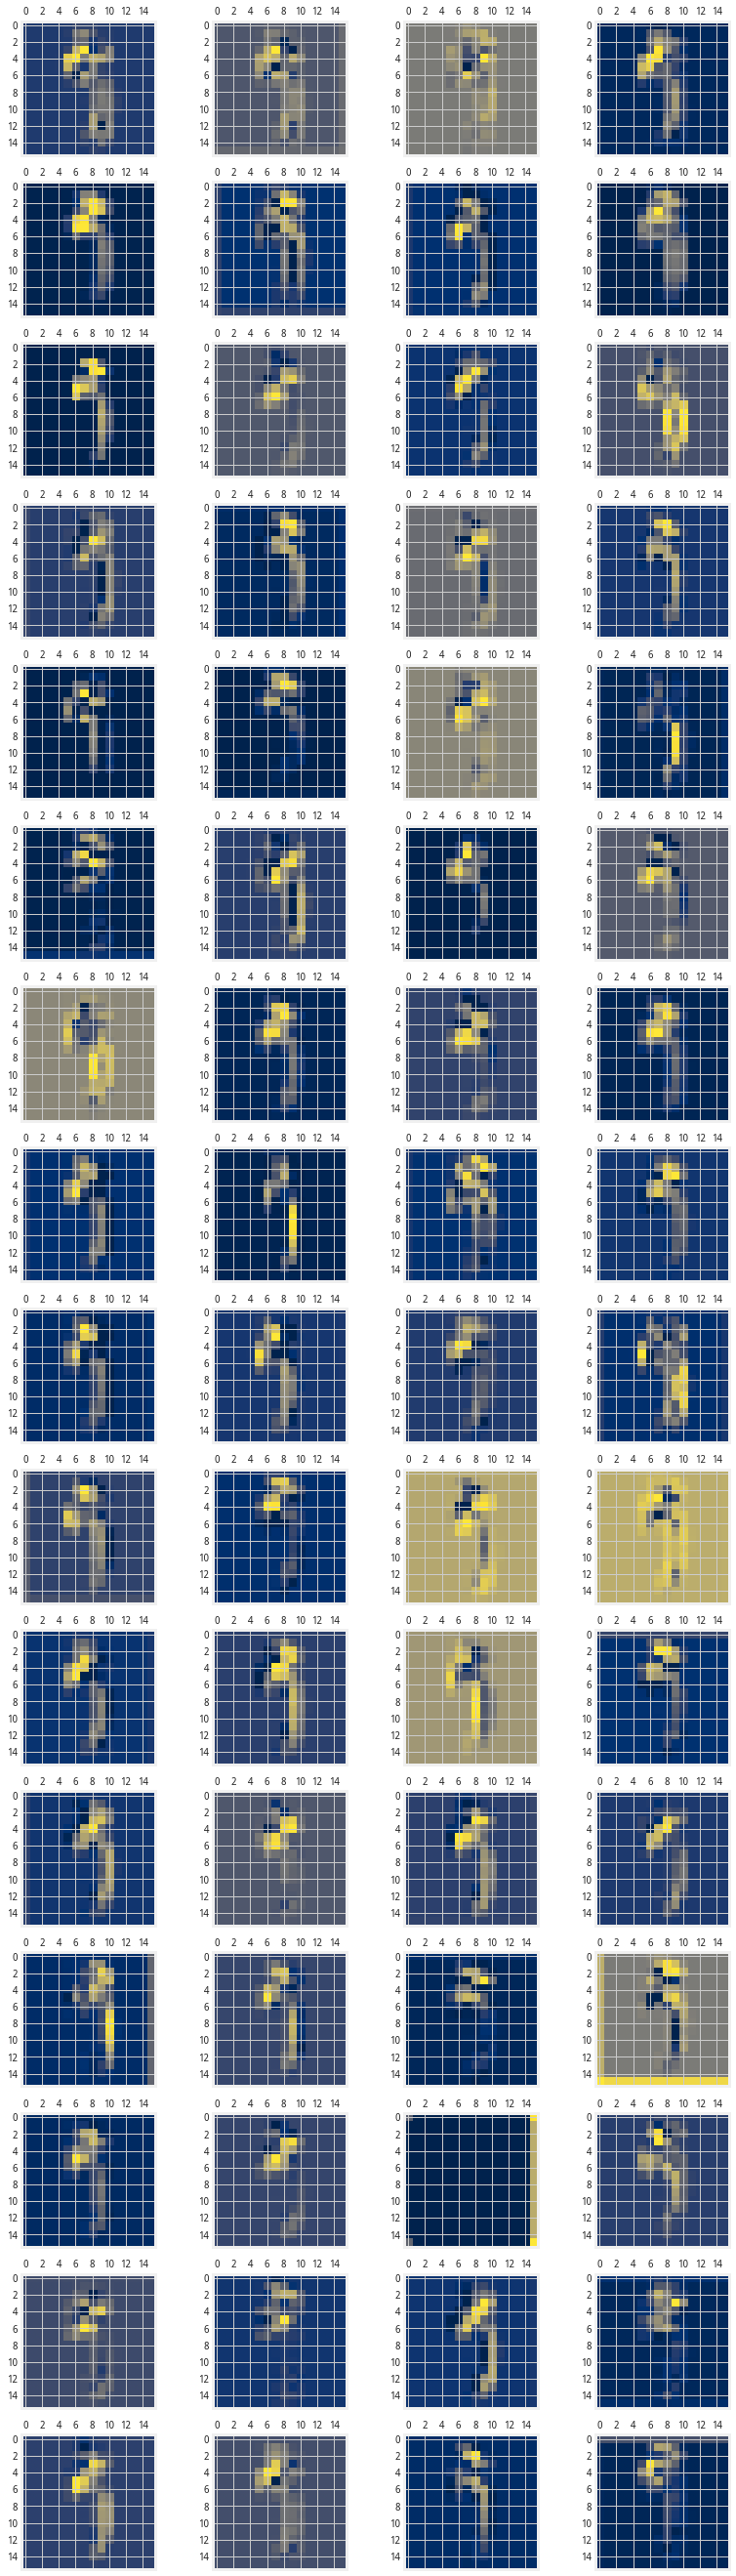

In [376]:
fig, axes = plt.subplots(16, 4, figsize=(12,48))
for i in range(64):
    row = i//4
    column = i%4
    ax = axes[row, column]
    ax.matshow(fourth_layer_activation[0, :, :, i], cmap='cividis')

In [359]:
tenth_layer_activation = cnn_layers[10]
print(tenth_layer_activation.shape)

(1, 4, 4, 256)


As this model gets farther down the convolution line, it's resolution becomes reduced while the number of channels increases greatly. In this particular layer for this model, it appears that the vast majority of channels were underutilized.

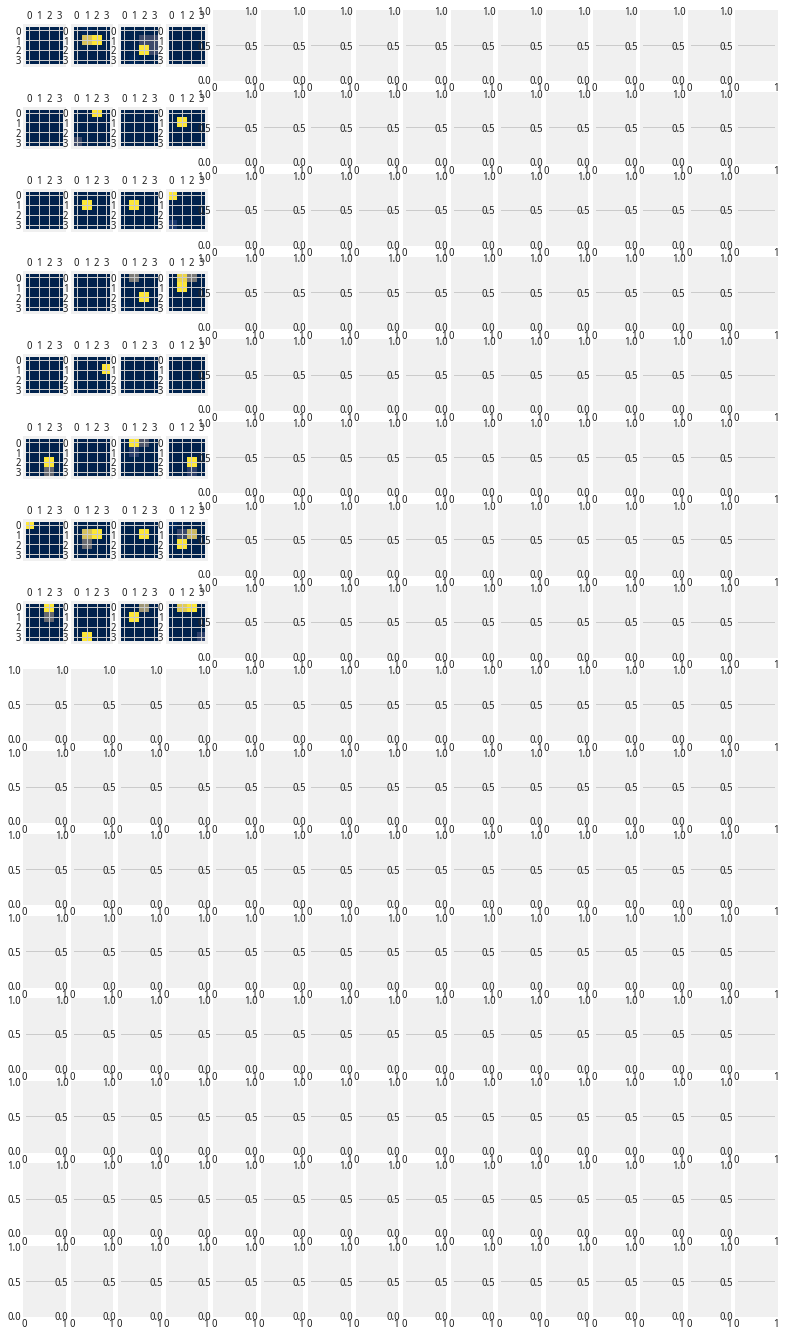

In [377]:
fig, axes = plt.subplots(16, 16, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    ax.matshow(tenth_layer_activation[0, :, :, i], cmap='cividis')

Perhaps this particular model is overly complex and would benefit from a reduction of cnn layers. The next logical step would be to see if there is a happy medium between the 2nd and third models. Possibly avoiding transfer learning from those libraries all together and instead leaveraging the full kuzushiji dataset with Kanji to build the inital hidden layers and eliminate the need for redunency in the other channels.